# Labels mapping characteristics and filtering

Depending on the quality of your segmentation, it will be interesting to filter your labels based on different characteristics of your dataset, like size, intensity, etc.

In this case, the result using stardist and a generalistic ML confidence-based pixel classifier generates an over-segmentation. This issue will be easily solved by setting a mean intensity threshold to remove the low-intensity labels representing negative signal cells.

### Setting up your requirements

We will use 'NumPy' to handle our arrays, 'napari' to visualize our data, 'Zarr' to load and save our results.

Also, we will use two functions from 'scikit-image', 'measure_regionprops_table' to list the properties of our labels based on the raw data, and 'util_map_array' to extract the labels that we want. 'pandas' is going to be used to handle the extracted statistics.

Last, we use 'matplotlib' to plot some graphs that will help us decide the limits to select the labels.

In [1]:
import numpy as np
import napari
import pandas
import zarr
import matplotlib.pyplot as plt
#import tiffile as tf
#from skimage.measure import regionprops_table
#from skimage.util import map_array

### Loading your data
Here you have to indicate where your files are stored, you can use zarr format that will result in smaller and manageable files, but you can use tif files in the same way.

In [2]:
# load raw data

image = zarr.load(r"D:\EHG\Explants\INSL3\C2-EH3931_SAG7_Explant-3_5-COUPTFII_6-INSL3_7-CYP17A1-1s_12x_1z_Blaze_C0.ome_Processed.aivia_Processed.aivia.tif80.zarr")
#image = tf.imread(r"F:\stardist_seg\raw.tif")

# Load the segmented image

labels = zarr.load(r"D:\EHG\Explants\INSL3\Labels\C2-EH3931_SAG7_Explant-3_5-COUPTFII_6-INSL3_7-CYP17A1-1s_12x_1z_Blaze_C0.ome_Processed.aivia_Processed.aivia_cp_masks.tif29.zarr")
#labels = tf.imread(r"F:\stardist_seg\labels.tif")

#intensity_labels = zarr.load(r"F:\stardist_seg\lab_intensity.zarr")

### Inspect your data using Napari (Optional)

We are going to use Napari to visualize our data

In [ ]:
viewer = napari.Viewer()

Then, we add the datasets to Napari

In [ ]:
viewer.add_image(image)
viewer.add_labels(labels)
#viewer.add_labels(intensity_labels)

In [ ]:
viewer.layers['labels'].scale = [3.69, 1, 1]
viewer.layers['image'].scale = [3.69, 1, 1]
#viewer.layers['intensity_labels'].scale = [3.69, 1, 1]


### Extracting the labels features

Using the 'regioprops_table' function, we can extract some label characteristics that will help us to decide which threshold can be applied for or case. 


In [3]:
from napari_simpleitk_image_processing import label_statistics
import pandas as pd
import time

for i in range(0, 10):
    start_time = time.time()
    
    # get dictionary of measurements
    props = label_statistics(image, labels, None, True, True, True, True, True, True)
        
    # read out arrays of values
    content = pd.DataFrame(props)

    max_vector = content['maximum']
    mean_vector = content['mean']
    min_vector = content['minimum']
    feret_vector = content['feret_diameter']
    pixel_vector = content['number_of_pixels']
    sum_vector = content['sum']
    rad_vector = content['equivalent_spherical_radius']
    per_vector = content['perimeter']
    flat_vector = content['flatness']
    rou_vector = content['roundness']
        
    print("Determining label statistics using simpleitk took " + str(time.time() - start_time) + " s")

Determining label statistics using simpleitk took 16.846405744552612 s
Determining label statistics using simpleitk took 12.15662431716919 s
Determining label statistics using simpleitk took 12.36299991607666 s
Determining label statistics using simpleitk took 13.362192153930664 s
Determining label statistics using simpleitk took 13.918826580047607 s
Determining label statistics using simpleitk took 13.059139728546143 s
Determining label statistics using simpleitk took 12.421416521072388 s
Determining label statistics using simpleitk took 12.87656021118164 s
Determining label statistics using simpleitk took 12.485944986343384 s
Determining label statistics using simpleitk took 13.239392518997192 s


Then, we can use pandas to structure the results array.

In [ ]:
content

We can retrieve the different vectors of interest to be evaluated.

Then, we can get a look of our labels using matplotlib to plot the frequency histograms.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

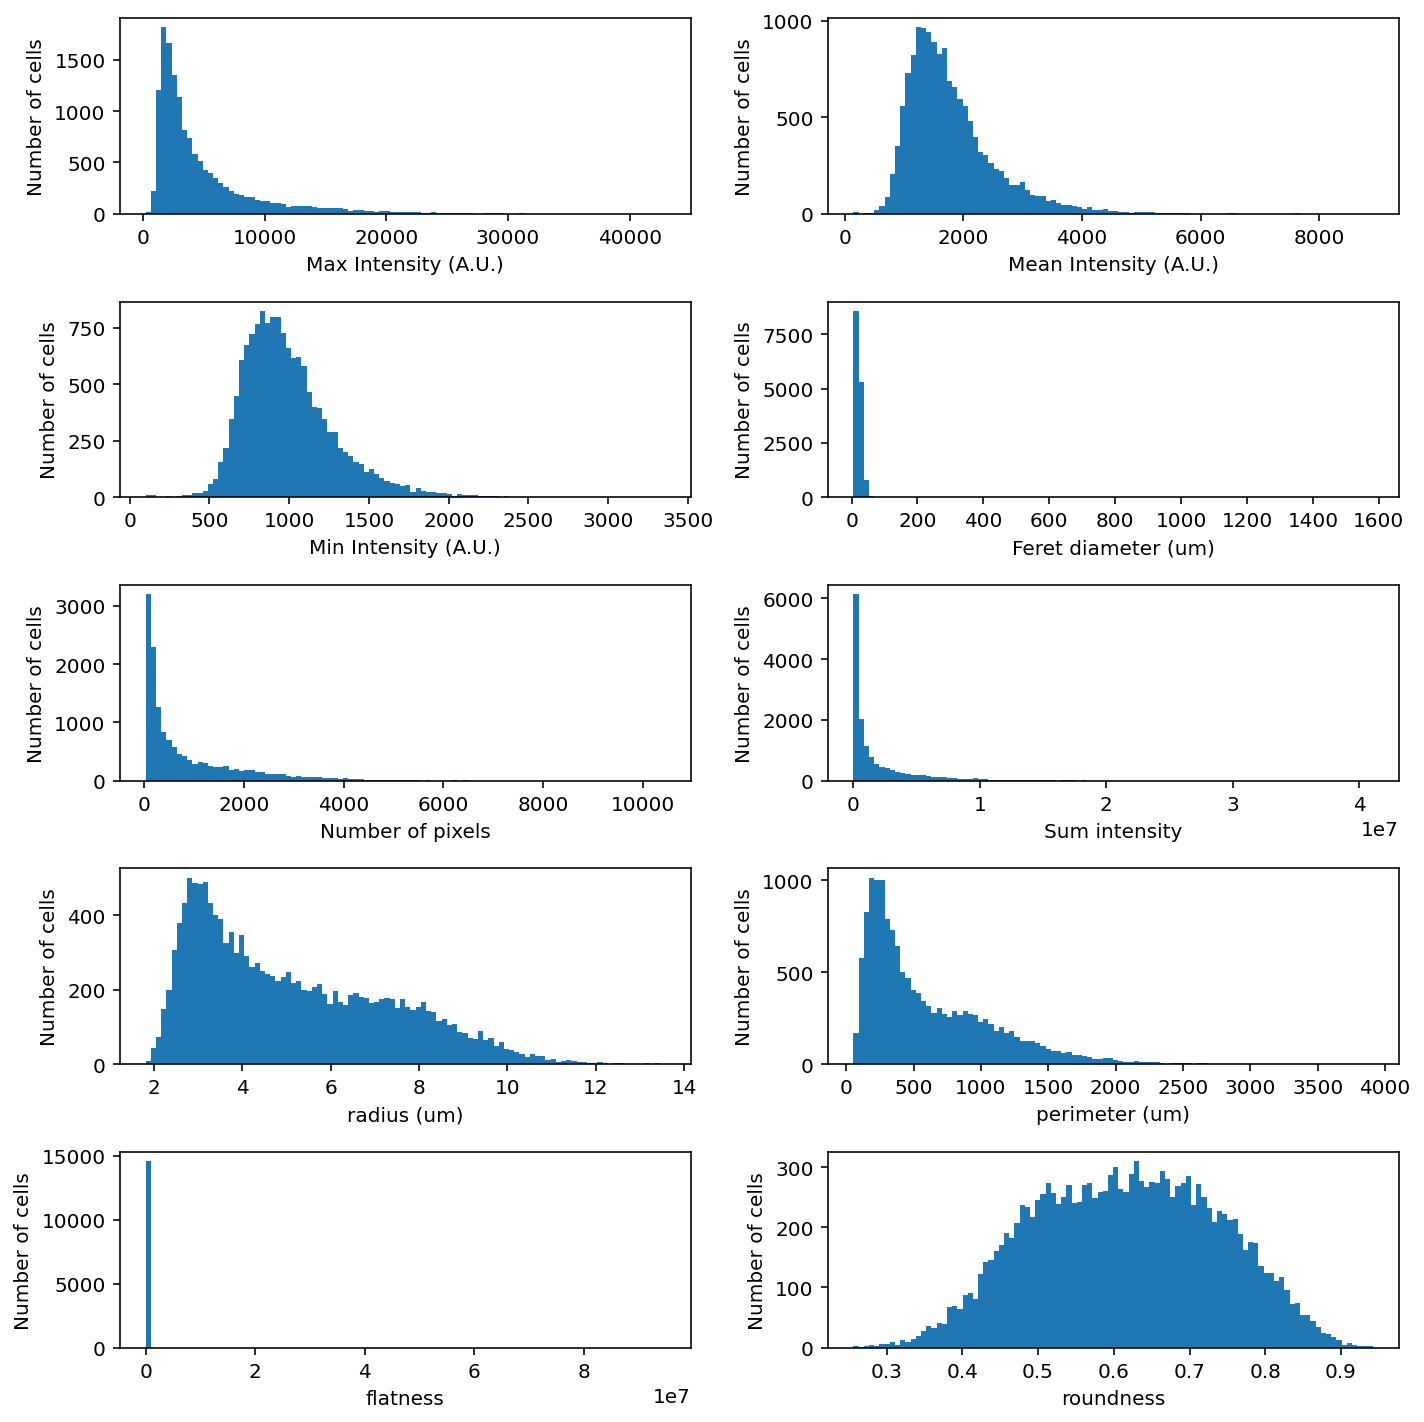

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(10,10))
ax = axes.ravel()


ax[0].hist(max_vector, bins=100)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Max Intensity (A.U.)')

ax[1].hist(mean_vector, bins=100)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Mean Intensity (A.U.)')

ax[2].hist(min_vector, bins=100)
ax[2].set_ylabel('Number of cells')
ax[2].set_xlabel('Min Intensity (A.U.)')

ax[3].hist(feret_vector, bins=100)
ax[3].set_ylabel('Number of cells')
ax[3].set_xlabel('Feret diameter (um)') 

ax[4].hist(pixel_vector, bins=100)
ax[4].set_ylabel('Number of cells')
ax[4].set_xlabel('Number of pixels')

ax[5].hist(sum_vector, bins=100)
ax[5].set_ylabel('Number of cells')
ax[5].set_xlabel('Sum intensity')

ax[6].hist(rad_vector, bins=100)
ax[6].set_ylabel('Number of cells')
ax[6].set_xlabel('radius (um)')

ax[7].hist(per_vector, bins=100)
ax[7].set_ylabel('Number of cells')
ax[7].set_xlabel('perimeter (um)')

ax[8].hist(flat_vector, bins=100)
ax[8].set_ylabel('Number of cells')
ax[8].set_xlabel('flatness')

ax[9].hist(rou_vector, bins=100)
ax[9].set_ylabel('Number of cells')
ax[9].set_xlabel('roundness')

fig.tight_layout()

From those histograms we can see that there are two populations of cells, this allow us to think that cells that have a instensity of 4000 or higher ca be considerated positives.

### Selecting labels above a given intensity threshold

To generate the labels image of the nuclei with an intensity higher than 4000 we can use the 'map_array' funtion from 'scikit-image' mapping the *product* of the boolean array with the labels.

In [6]:
from skimage.util import map_array

intensity_labels  = map_array(
    labels,
    label_ids := np.asarray(content['label']),
    label_ids * np.asarray(content['mean'] > 1500),
)

Then we can add our new labels to Napari

In [ ]:
viewer.add_labels(intensity_labels)

### Saving the new labels

We can save our new generated labels as *zarr* file using the 'convenience.save' function

In [ ]:
zarr.convenience.save(r"D:\EHG\Explants\INSL3\results\C2-EH3931_SAG7_Explant-3.zarr", intensity_labels)

### Getting the properties of the new set of labels
Finally, we can extract the properties of our new set of labels and format them with pandas

In [7]:
for i in range(0, 10):
    start_time = time.time()
    
    # get dictionary of measurements
    props_int = label_statistics(image, intensity_labels, None, True, True, True, True, True, True)
    
    # read out arrays of values
    content_int = pandas.DataFrame(props_int)
    
    max_vec = content_int['maximum']
    mean_vec = content_int['mean']
    min_vec = content_int['minimum']
    feret_vec = content_int['feret_diameter']
    pixel_vec = content_int['number_of_pixels']
    sum_vec = content_int['sum']
    rad_vec = content_int['equivalent_spherical_radius']
    per_vec = content_int['perimeter']
    flat_vec = content_int['flatness']
    rou_vec = content_int['roundness']    

print("Determining label statistics using simpleitk took " + str(time.time() - start_time) + " s")

Determining label statistics using simpleitk took 18.144030809402466 s


In [ ]:
content_int

Here, we can see the final count of cells in the dataset

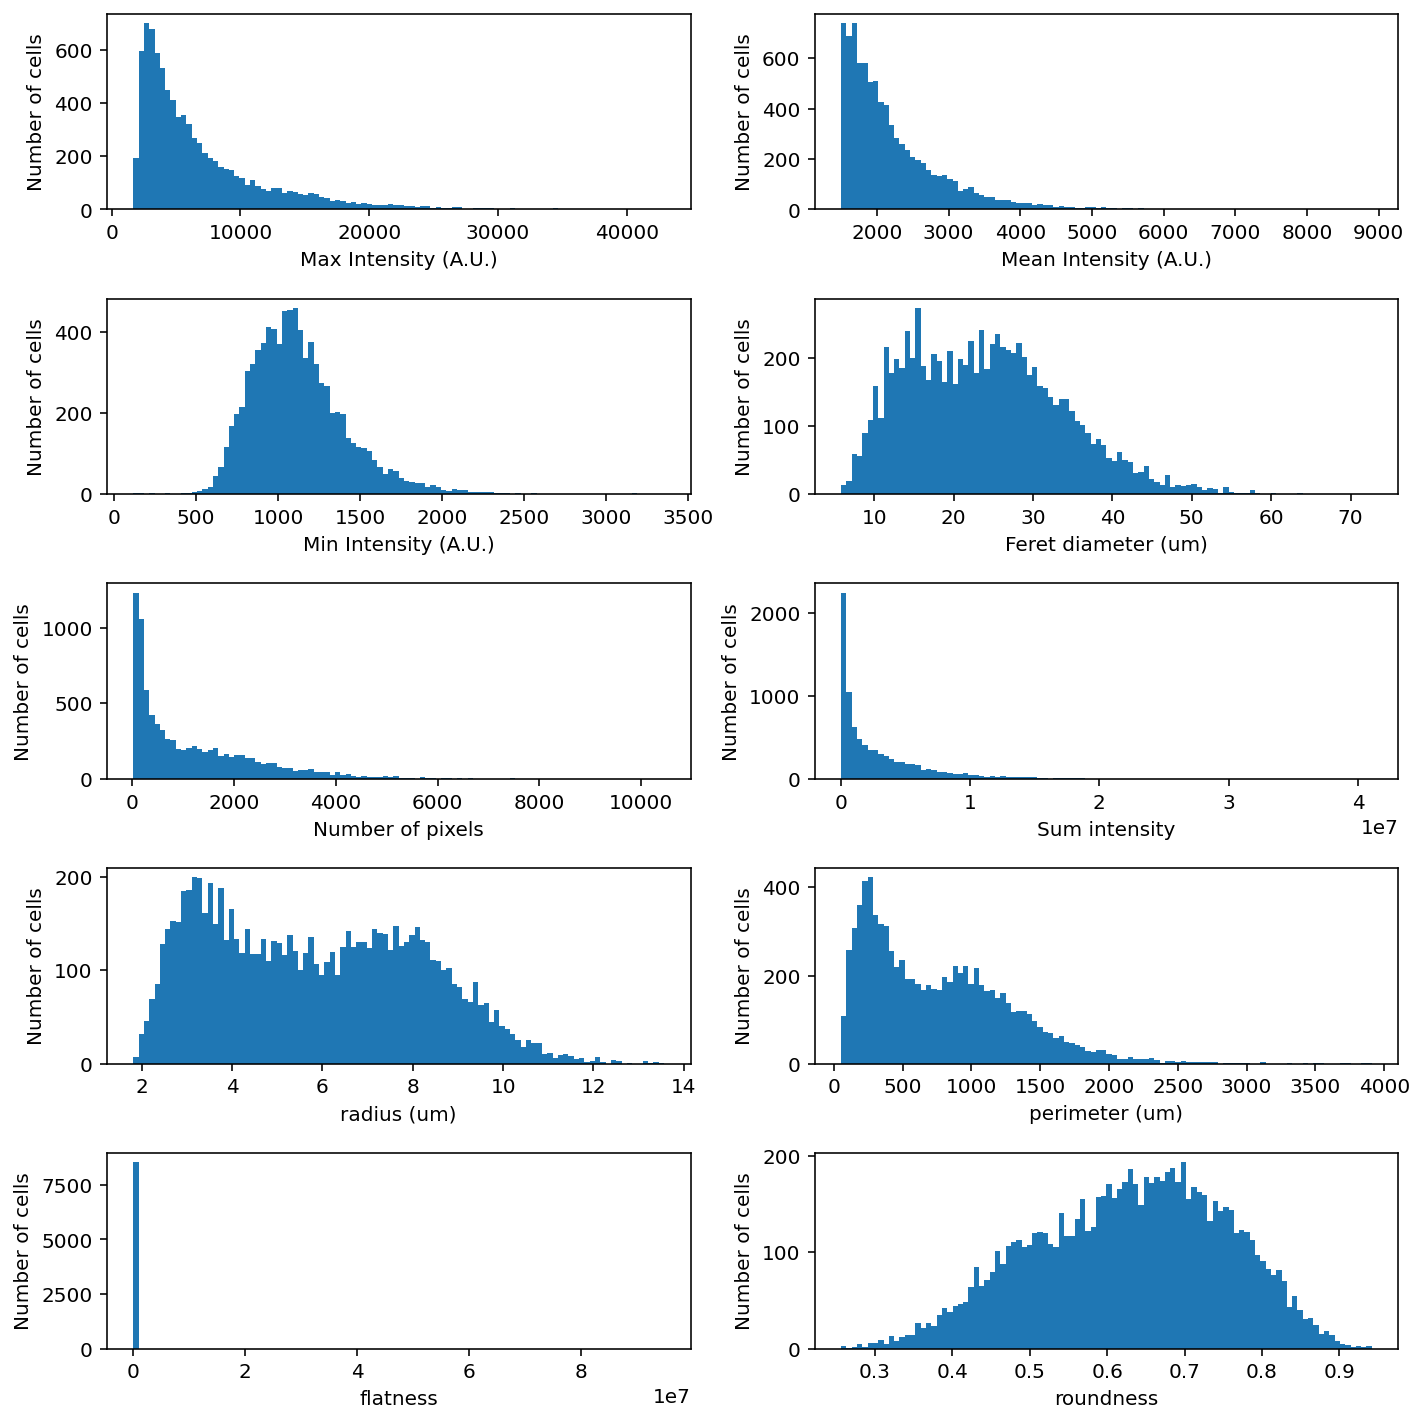

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(10,10))
ax = axes.ravel()


ax[0].hist(max_vec, bins=100)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Max Intensity (A.U.)')

ax[1].hist(mean_vec, bins=100)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Mean Intensity (A.U.)')

ax[2].hist(min_vec, bins=100)
ax[2].set_ylabel('Number of cells')
ax[2].set_xlabel('Min Intensity (A.U.)')

ax[3].hist(feret_vec, bins=100)
ax[3].set_ylabel('Number of cells')
ax[3].set_xlabel('Feret diameter (um)') 

ax[4].hist(pixel_vec, bins=100)
ax[4].set_ylabel('Number of cells')
ax[4].set_xlabel('Number of pixels')

ax[5].hist(sum_vec, bins=100)
ax[5].set_ylabel('Number of cells')
ax[5].set_xlabel('Sum intensity')

ax[6].hist(rad_vec, bins=100)
ax[6].set_ylabel('Number of cells')
ax[6].set_xlabel('radius (um)')

ax[7].hist(per_vec, bins=100)
ax[7].set_ylabel('Number of cells')
ax[7].set_xlabel('perimeter (um)')

ax[8].hist(flat_vec, bins=100)
ax[8].set_ylabel('Number of cells')
ax[8].set_xlabel('flatness')

ax[9].hist(rou_vec, bins=100)
ax[9].set_ylabel('Number of cells')
ax[9].set_xlabel('roundness')

fig.tight_layout()

In [9]:
int_labels = map_array(
    labels,
    label_ids := np.asarray(content_int['label']),
    label_ids * np.asarray(content_int['perimeter'] > 500),
)

In [10]:
zarr.convenience.save(r"D:\EHG\Explants\INSL3\results\C2-EH3931_SAG7_Explant-3.zarr", int_labels)

In [11]:
for i in range(0, 10):
    start_time = time.time()
    
    # get dictionary of measurements
    props2_int = label_statistics(image, int_labels, None, True, True, True, True, True, True)
    
    # read out arrays of values
    content_int = pandas.DataFrame(props2_int)
    
    max_vec = content_int['maximum']
    mean_vec = content_int['mean']
    min_vec = content_int['minimum']
    feret_vec = content_int['feret_diameter']
    pixel_vec = content_int['number_of_pixels']
    sum_vec = content_int['sum']
    rad_vec = content_int['equivalent_spherical_radius']
    per_vec = content_int['perimeter']
    flat_vec = content_int['flatness']
    rou_vec = content_int['roundness']    

print("Determining label statistics using simpleitk took " + str(time.time() - start_time) + " s")

Determining label statistics using simpleitk took 18.46396541595459 s


In [12]:
content_int

,label,maximum,mean,median,minimum,sigma,sum,variance,bbox_0,bbox_1,...,principal_axes2,principal_axes3,principal_axes4,principal_axes5,principal_axes6,principal_axes7,principal_axes8,principal_moments0,principal_moments1,principal_moments2
0,4,23816.0,1842.603963,895.986328,125.0,2517.532546,6974256.0,6.337970e+06,1232,1113,...,0.948950,0.110015,0.959380,-0.259783,-0.970807,0.159770,0.178904,13.356777,17.687740,46.425169
1,6,20193.0,1984.347099,1151.982422,117.0,2374.239809,13646355.0,5.637015e+06,1359,681,...,-0.439912,0.351530,0.346957,0.869510,0.907026,-0.356192,-0.224568,23.131858,29.831096,44.692629
2,13,9413.0,1556.161840,1407.978516,158.0,1151.784531,6394269.0,1.326608e+06,1234,679,...,0.994259,-0.308338,-0.946381,0.096388,0.951165,-0.305165,0.046465,7.071387,24.660633,59.124925
3,26,16977.0,1582.048366,895.986328,150.0,2060.126258,4841068.0,4.244120e+06,1166,1146,...,0.998511,0.980516,0.190139,-0.049360,-0.189194,0.981666,0.023204,6.105257,22.997506,35.424794
4,31,10395.0,2305.205197,1663.974609,638.0,1547.770100,7717827.0,2.395592e+06,1205,904,...,0.991853,-0.545917,0.832856,0.091249,-0.837471,-0.539203,-0.088893,4.938287,28.530588,49.109733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,14661,4693.0,1533.280468,1407.978516,767.0,666.971498,2881034.0,4.448510e+05,957,1909,...,0.999885,0.969025,0.246648,0.012479,-0.246554,0.969091,-0.008605,1.145930,35.852944,42.409686
5143,14663,9780.0,2918.635854,2175.966797,1183.0,1672.424481,2083906.0,2.797004e+06,880,2201,...,0.998104,0.120594,-0.991025,0.057681,0.992597,0.119535,-0.021488,0.589030,18.226382,26.636200
5144,14666,6922.0,1711.077220,1407.978516,335.0,1235.813967,1329507.0,1.527236e+06,935,1779,...,0.997972,0.208336,-0.977357,-0.037000,0.976312,0.210074,-0.051799,0.936640,11.472565,29.108098
5145,14680,11043.0,2618.515068,2175.966797,808.0,1778.161309,1911516.0,3.161858e+06,993,2087,...,0.999655,-0.039369,-0.998920,-0.024657,0.999174,-0.039603,0.009095,0.634702,14.262408,27.428307


In [13]:
!pip install napari-error-reporter

     -------------------------------------- 144.8/144.8 KB 4.3 MB/s eta 0:00:00
